# Unbinned analysis: Localizing a source

In [88]:
## Analysis

In [70]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from gammaraytoys.detectors import Simulator, SimpleTraditionalReconstructor
from gammaraytoys.detectors import PointSource, PowerLawSpectrum, MonoenergeticSpectrum
from histpy import Histogram, Axis

source_nu = 30*u.deg
source_flux = 1e-1/u.cm/u.s
bkg_rate = 1000*u.Hz
duration = 1 *u.s

# Detector 
det = ToyTracker2D(material = 'Ge',
                   layer_length = 10*u.m, 
                   layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                   layer_thickness = 1*u.cm, 
                   energy_resolution = 0.03,
                   energy_threshold = 20*u.keV)

# Source
source = PointSource(offaxis_angle = source_nu,
                     spectrum = MonoenergeticSpectrum(energy = 1*u.MeV),
                     flux = source_flux)

# Getting Em and the CDS
reco = SimpleTraditionalReconstructor()
    
# Sims
sims = Simulator(detector = det, 
                 sources = source, 
                 reconstructor = reco)

event_data_phi = []
event_data_psi = []

for sim_event, reco_event in sims.run_events(duration = duration):
    
        if reco_event.triggered:
            
            event_data_phi += [reco_event.phi]
            event_data_psi += [reco_event.psi]

nevents_signal = len(event_data_psi)

nevents_bkg = int((duration * bkg_rate).to_value(''))
print(nevents_bkg)

bkg_events_psi = np.random.uniform(-180,180, size = nevents_bkg)*u.deg
bkg_events_phi = np.random.uniform(0,180, size = nevents_bkg)*u.deg

event_data_psi = u.Quantity(np.concatenate([event_data_psi, bkg_events_psi]))
event_data_phi = u.Quantity(np.concatenate([event_data_phi, bkg_events_phi]))

1000: 104/104 ntrig = 31


In [71]:
nexpected = (source_flux * duration * Aeff.interp(source_nu, 0)).to_value('') 
nexpected

np.float64(35.320445449154)

In [72]:
(nevents_signal-nexpected)/nexpected

np.float64(-0.12232137489244163)

In [73]:
(nevents_signal-nexpected)/np.sqrt(nexpected)

np.float64(-0.7269682437963229)

(<Axes: xlabel='Psi [deg]', ylabel='Phi [deg]'>,
 <matplotlib.collections.QuadMesh at 0x12b970bf0>)

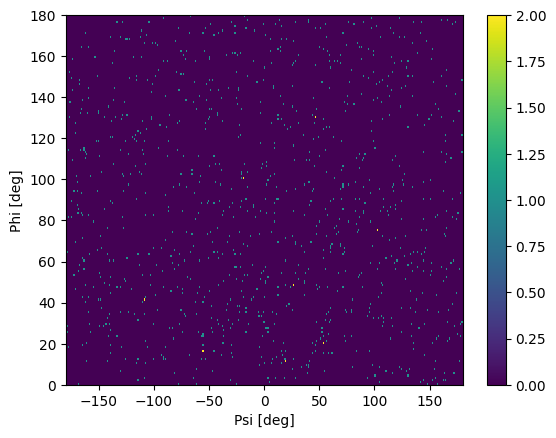

In [74]:
binned_data = Histogram([Axis(np.linspace(-180,180, 360+1)*u.deg, label = 'Psi'),
                         Axis(np.linspace(0,180, 180+1)*u.deg, label = 'Phi')])        

binned_data.fill(event_data_psi, event_data_phi)

binned_data.plot()

In [75]:
nevents = event_data_psi.size
nevents

1031

In [76]:
np.prod(binned_data.nbins)

np.int64(64800)

In the real case this became even worst. Distributed in 3D, time (SC is rotating) and energy (continous). Even longer duration are in this regime. 

Unbinned likelihood calculation here

(<Axes: xlabel='Psi [deg]', ylabel='Phi [deg]'>,
 <matplotlib.collections.QuadMesh at 0x12b90bb90>)

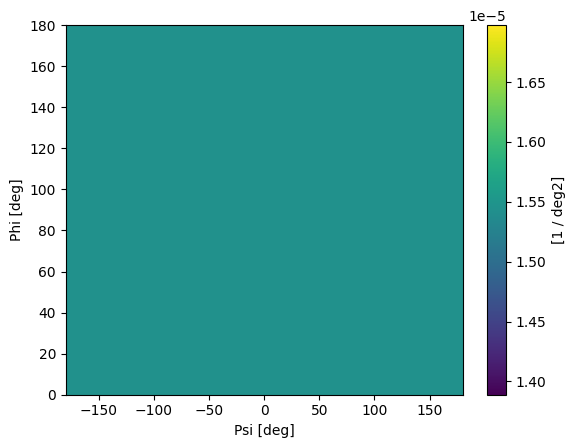

In [77]:
bkg_model = Histogram(binned_data.axes,
                      1 / (binned_data.axes['Psi'].widths[:,None] * 
                           binned_data.axes['Phi'].widths[None,:]) / np.prod(binned_data.nbins))

bkg_model.plot()

In [87]:
Aeff = Histogram.open("Aeff_chiral_img_1MeV_traddet.h5")
chiral_img_pdf = Histogram.open("PDF_delta_chiral_img_1MeV_traddet.h5")

In [91]:
# Same file
Aeff.write("response_imaging_chiral_relative_1MeV_traddet.h5", name = 'Aeff')
chiral_img_pdf.write("response_imaging_chiral_relative_1MeV_traddet.h5", name = 'PDF')

In [85]:
#%%time

from gammaraytoys.analysis import poisson_binned_log_likelihood
from copy import deepcopy

# flux_hyp_axis = Axis(np.geomspace(1e-2, 1, 50)/u.cm/u.s, 
#                      label = 'flux', scale = 'log')
# Nu_hyp_axis = Axis(np.geomspace(25, 35, 51)*u.deg,
#                    label = 'energy')

flux_hyp_axis = Axis(np.geomspace(5e-2, 5e-1, 25)/u.cm/u.s, 
                     label = 'flux', scale = 'log')
Nu_hyp_axis = Axis(np.geomspace(28, 32, 25)*u.deg,
                   label = 'Nu')

log_like = Histogram([Nu_hyp_axis, flux_hyp_axis])

chirality = 0.5 # Will average

# Bkg
bkg_density = bkg_model.interp(event_data_psi, event_data_phi)

#
log_like0 = -nevents + np.sum(np.log(nevents * bkg_density.to_value(1/u.rad/u.rad)))

for nNu, Nu_hyp in enumerate(Nu_hyp_axis.centers):

    print(f"{nNu}/{Nu_hyp_axis.nbins}", end = '\r')
    
    # Transform to response delta coordinated
    phi = event_data_phi
    psi = deepcopy(event_data_psi)

    psi[psi > Nu_hyp + 180*u.deg] -= 360*u.deg
    psi[psi < Nu_hyp - 180*u.deg] += 360*u.deg

    zeta = 2*(Nu_hyp > psi) - 1

    arm = np.abs(psi - Nu_hyp) - phi

    chirality = 0 # No chirality

    # Get exposure
    
    # Remove those outside delta response
    in_response = ((arm > chiral_img_pdf.axes['ARM'].lo_lim) & (arm < chiral_img_pdf.axes['ARM'].hi_lim) & 
                   (phi > chiral_img_pdf.axes['Phi'].lo_lim) & (phi < chiral_img_pdf.axes['Phi'].hi_lim))

    # Compute densities. Will include normalization inner loop
    
    # Signal exposure
    exposure = duration * Aeff.interp(Nu_hyp, chirality)
    
    exposure_density = np.zeros(phi.size)/u.rad/u.rad

    exposure_density[in_response] = chiral_img_pdf.interp(Nu_hyp, chirality, phi[in_response], arm[in_response], zeta[in_response])

    for nflux, flux_hyp in enumerate(flux_hyp_axis.centers):

        tot_expectation_signal = (flux_hyp * exposure).to_value('')
        
        estimated_bkg_counts = np.maximum(0, nevents - tot_expectation_signal)
        
        total_expectation = estimated_bkg_counts + tot_expectation_signal # Nevent. but left general
    
        expectation_density_signal = tot_expectation_signal * exposure_density
        
        expectation_density_bkg = estimated_bkg_counts * bkg_density
        
        expectation_density = expectation_density_bkg + expectation_density_signal
        
        # Unit conversion become constant. Doesn't matter as long as everything same unit
        log_like[nNu, nflux] = -total_expectation + np.sum(np.log(expectation_density.to_value(1/u.rad/u.rad))) 
        

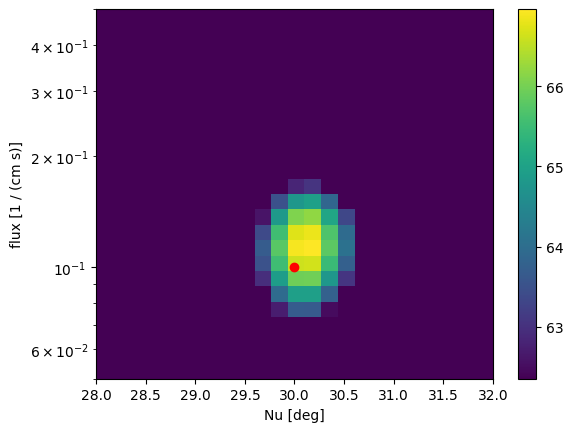

In [86]:
from scipy.stats import chi2

ts = 2*(log_like - log_like0)

argmax_ts = np.unravel_index(np.argmax(ts), ts.nbins)
max_ts = ts[argmax_ts]

nu_opt = ts.axes[0].centers[argmax_ts[0]] 
flux_opt = ts.axes[1].centers[argmax_ts[1]] 

uncertainty_containment = .9
unc_contour_ts = max_ts - chi2.ppf(uncertainty_containment, df = 2)

fig,ax = plt.subplots()

ts.plot(ax, vmin =  unc_contour_ts)

ax.scatter(source_nu.to_value(u.deg), source_flux.to_value(1/u.cm/u.s), color = 'red')

#ax.set_xlim(1,3)

In [ ]:
## Response creator

In [1]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from gammaraytoys.detectors import Simulator, SimpleTraditionalReconstructor
from gammaraytoys.detectors import PointSource, PowerLawSpectrum, MonoenergeticSpectrum
from histpy import Histogram, Axis

offaxis_angle_axis = Axis(np.linspace(-180, 180, 361)*u.deg, label = 'Nu')
offaxis_angle_axis = Axis(np.linspace(-80, 80, 16+1+1)*u.deg, label = 'Nu') # ~10 deg, cnetered 0
chirality_axis = Axis([-2,0,2], label = 'k')
# phi_axis = Axis(np.linspace(0,180, 181)*u.deg, label = 'Phi')
# arm_axis = Axis(np.linspace(-180,180, 361)*u.deg, label = 'ARM')

#offaxis_angle_axis = Axis(np.linspace(-60, 60, 120+1)*u.deg, label = 'Nu')
phi_axis = Axis(np.concatenate([np.linspace(0,30, 10+1)[:-1],
                                np.linspace(30,80, 10+1)[:-1],
                                np.linspace(80,180, 10+1)
                               ])*u.deg, 
                label = 'Phi')
arm_axis = Axis(np.concatenate([np.linspace(-180,-73, 10+1)[:-1],
                                np.linspace(-73,-15, 10+1)[:-1],
                                np.linspace(-15,-3, 6+1)[:-1], #2deg
                                np.linspace(-3,3, 7+1)[:-1], # ~1deg. Centered 0
                                np.linspace(3,9, 3+1)[:-1], # 2deg
                                np.linspace(9,73, 11+1)[:-1],
                                np.linspace(73,180, 10+1)
                               ])*u.deg, label = 'ARM')

#side_axis = Axis([-2,0,2], label = 'side')
zeta_axis = Axis([-2,0,2], label = 'Zeta')


# Detector 
det = ToyTracker2D(material = 'Ge',
                   layer_length = 10*u.m, 
                   layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                   layer_thickness = 1*u.cm, 
                   energy_resolution = 0.03,
                   energy_threshold = 20*u.keV)

In [2]:
h_data_delta = Histogram([offaxis_angle_axis,chirality_axis,phi_axis,arm_axis,zeta_axis])
h_nsim = Histogram([offaxis_angle_axis, chirality_axis])

In [3]:
%%time

ntrig = 20000 #per nu bin
nsim = None

nu = (0)*u.deg
nNu_select = h_data_delta.axes["Nu"].find_bin(nu)

for nNu,nu in enumerate(h_data_delta.axes['Nu'].centers):

    # if nNu != nNu_select:
    #     continue
    
    print(f"{nNu}/{h_data_delta.axes['Nu'].nbins}")

    # Source
    source = PointSource(offaxis_angle = nu,
                         spectrum = MonoenergeticSpectrum(energy = 1*u.MeV))
    
    # Getting Em and the CDS
    reco = SimpleTraditionalReconstructor()
    
    # Sims
    sims = Simulator(detector = det, 
                     sources = source, 
                     reconstructor = reco)
    
    for sim_event, reco_event in sims.run_events(ntrig = ntrig, nsim = nsim):
    
        h_nsim.fill(nu, sim_event.chirality)
        
        if reco_event.triggered:

            psi = reco_event.psi

            phi = reco_event.phi

            if psi > nu + 180*u.deg:
                psi -= 360*u.deg

            if psi < nu - 180*u.deg:
                psi += 360*u.deg
            
            if psi - nu > 0:
                zeta = -1
            else:
                zeta = 1

            arm = np.abs(psi - nu) - phi
                        
            h_data_delta.fill(nu, sim_event.chirality, phi, arm, zeta)


0/17


/Users/israel/work/software/miniconda3/envs/gammaraytoys/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


/Users/israel/work/software/miniconda3/envs/gammaraytoys/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/israel/work/software/miniconda3/envs/gammaraytoys/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1/17g = 20000/20000 nsim: 331765
2/17g = 20000/20000 nsim: 188174
3/17g = 20000/20000 nsim: 126535
4/17g = 20000/20000 nsim: 90310
5/17g = 20000/20000 nsim: 69364
6/17g = 20000/20000 nsim: 56412
7/17g = 20000/20000 nsim: 50162
8/17g = 20000/20000 nsim: 47211
9/17g = 20000/20000 nsim: 46326
10/17 = 20000/20000 nsim: 46827
11/17 = 20000/20000 nsim: 50112
12/17 = 20000/20000 nsim: 57234
13/17 = 20000/20000 nsim: 69221
14/17 = 20000/20000 nsim: 90111
15/17 = 20000/20000 nsim: 125693
16/17 = 20000/20000 nsim: 189650
CPU times: user 5h 32min 54s, sys: 21min 50s, total: 5h 54min 44s
Wall time: 6h 25min 34s


In [4]:
h_data_delta.write("h_data_delta_chiral_img_full.h5", overwrite = False)
h_nsim.write("h_nsim_chiral_img_full.h5", overwrite = False)

In [23]:
# Fix sims
h_data_delta = Histogram.open("h_data_delta_chiral_img.h5.back")
h_nsim = Histogram.open("h_nsim_chiral_img.h5.back")

# Fix zeta (-side) definition
zeta_axis = Axis([-2,0,2], label = 'Zeta')
h_data_delta_aux = Histogram([h_data_delta.axes['Nu'],
                              h_data_delta.axes['k'],
                              h_data_delta.axes['Phi'],
                              h_data_delta.axes['ARM'],
                              zeta_axis])

h_data_delta_aux[:,:,:,:,0] = h_data_delta[:,:,:,:,1]
h_data_delta_aux[:,:,:,:,1] = h_data_delta[:,:,:,:,0]

# Fix no tracking of chirality
chirality_axis = Axis([-2,0,2], label = 'k')
h_nsim_aux = Histogram([h_nsim.axes['Nu'], chirality_axis])
h_nsim_aux[:,0] = np.round(h_nsim[:]/2)
h_nsim_aux[:,1] = np.round(h_nsim[:]/2)

h_data_delta_aux.write("h_data_delta_chiral_img.h5")
h_nsim_aux.write("h_nsim_chiral_img.h5")

In [11]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from gammaraytoys.detectors import Simulator, SimpleTraditionalReconstructor
from gammaraytoys.detectors import PointSource, PowerLawSpectrum, MonoenergeticSpectrum
from histpy import Histogram, Axis

h_data_delta = Histogram.open("h_data_delta_chiral_img.h5")
h_nsim = Histogram.open("h_nsim_chiral_img.h5")

/Users/israel/work/software/histpy/histpy/histogram.py:1407: RuntimeWarning: invalid value encountered in divide
  new_contents = operation(self.full_contents, other_contents)


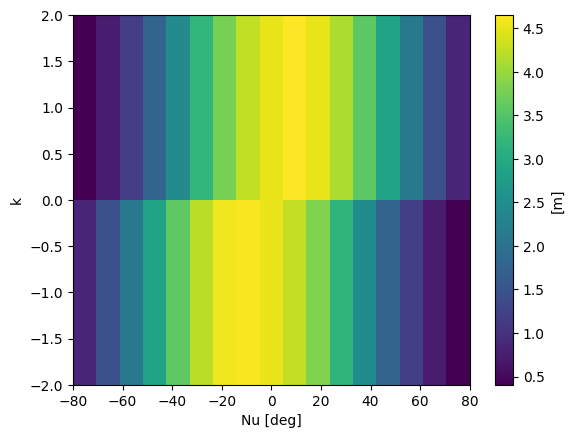

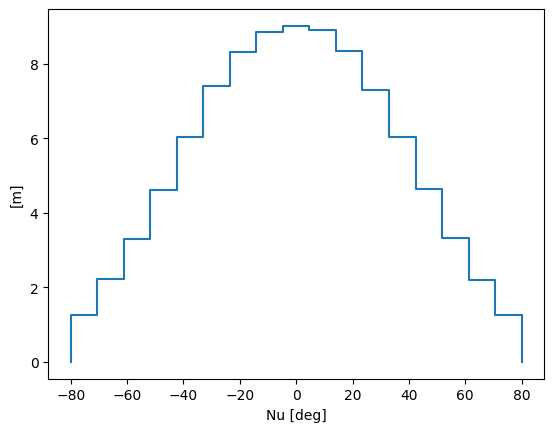

In [5]:
h_ntrig = h_data_delta.project("Nu",'k')
#h_ntrig.plot()
#h_nsim.plot()
Aeff = (h_ntrig/h_nsim) * det.throwing_plane_size
Aeff.clear_underflow_and_overflow()

ax,_ = Aeff.plot()
# ax.set_xlim(-180,180)
# ax.set_ylim(0,5)


ax,_ = Aeff.project('Nu').plot()

/Users/israel/work/software/histpy/histpy/histogram.py:1489: RuntimeWarning: invalid value encountered in divide
  self._contents = operation(self.full_contents, other)


<Quantity 9.8696044 rad2>

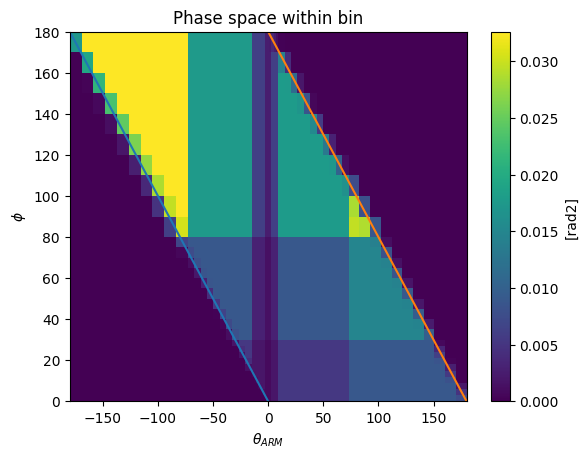

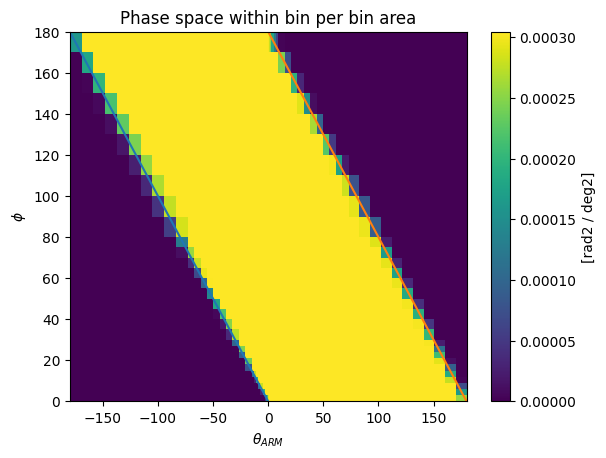

In [43]:
# Phase space

def phi_arm_phase_space(phi1, phi2, arm1, arm2):
    """
    Integrate phase space, accounting for the fact that the phi+arm range is limited to [0,pi]
    """
    
    # Standarize
    phi1 = phi1.to_value(u.rad)
    phi2 = phi2.to_value(u.rad)
    arm1 = arm1.to_value(u.rad)
    arm2 = arm2.to_value(u.rad)

    phi1, phi2, arm1, arm2 = np.broadcast_arrays(phi1, phi2, arm1, arm2)

    # Handle cases in between the physical boundaries
    # Integrate excluding unphysical corners
    # Remove unphysical rectangles
    arm1 = np.choose((arm1 < -phi2)        & (-phi2 < arm2),     [arm1, -phi2])
    arm2 = np.choose((arm1 < np.pi - phi1) & (np.pi-phi1 < arm2), [arm2, np.pi - phi1])    

    phi1 = np.choose((phi1 < -arm2)        & (-arm2 < phi2),     [phi1, -arm2])
    phi2 = np.choose((phi1 < np.pi - arm1) & (np.pi-arm1 < phi2), [phi2, np.pi - arm1])
    
    integral_rect = (arm2-arm1) * (phi2-phi1)

    # Remove unphysical corners (triangles or trapezoids)
    # Note the (phi1 + arm1) and (phi2 + arm2) masks in front

    # Lower left corner (low phi, low arm)
    phil = np.maximum(-arm2, phi1)
    phih = np.minimum(-arm1, phi2)
    arml = -phih
    armh = -phil
    unphys_lowerleft_integral = (armh-arml) * (phih-phil) / 2
    unphys_lowerleft_integral *= (phil + arm1) < 0
    integral = integral_rect -  unphys_lowerleft_integral

    # Upper right corner (high phi, high arm)
    phil = np.maximum(np.pi - arm2, phi1)
    phih = np.minimum(np.pi - arm1, phi2)
    arml = np.pi-phih
    armh = np.pi-phil
    unphys_upperright_integral = (armh-arml) * (phih-phil) / 2
    unphys_upperright_integral *= (phih + arm2) > np.pi
    integral -= unphys_upperright_integral

    # Unit back
    phase_units = u.rad*u.rad
    integral = integral*phase_units
    
    # Handle fully physical or fully unphysical
    fully_phys = (phi1 + arm1 >= 0) & (phi2 + arm2 <= np.pi)
    fully_unphys = (phi2 + arm2 <= 0) | (phi1 + arm1 >= np.pi)
    integral_full = integral_rect * phase_units
    
    if integral.ndim == 0:
        if fully_phys:
            return integral_full
        if fully_unphys:
            return 0 * phase_units
    else:
        integral[fully_phys] = integral_full[fully_phys]
        integral[fully_unphys] = 0 * phase_units
    
    return integral

### Plots and checks
angres = np.deg2rad(3) # Angular resolution. Will bin finely around Compton cone

# phi_axis = Axis(np.linspace(0,np.pi,18+1)*u.rad)
# arm_axis = Axis(np.concatenate((np.linspace(-np.pi, -3*angres, 12+1)[:-1], 
#                                 np.linspace(-3*angres, 3*angres, 13+1), 
#                                 np.linspace(3*angres, np.pi, 12+1)[1:]))*u.rad)

# phi_axis = Axis(np.linspace(0,np.pi,30+1)*u.rad)
# arm_axis = Axis(np.linspace(-np.pi,np.pi,60+1)*u.rad)

phi_axis = Axis(np.concatenate([np.linspace(0,30, 10+1)[:-1],
                                np.linspace(30,80, 10+1)[:-1],
                                np.linspace(80,180, 10+1)
                               ])*u.deg, 
                label = 'Phi')
arm_axis = Axis(np.concatenate([np.linspace(-180,-73, 10+1)[:-1],
                                np.linspace(-73,-15, 10+1)[:-1],
                                np.linspace(-15,-3, 6+1)[:-1], #2deg
                                np.linspace(-3,3, 7+1)[:-1], # ~1deg. Centered 0
                                np.linspace(3,9, 3+1)[:-1], # 2deg
                                np.linspace(9,73, 11+1)[:-1],
                                np.linspace(73,180, 11+1)
                               ])*u.deg, label = 'ARM')

# phi_axis = h_data_delta.axes['Phi']
# arm_axis = h_data_delta.axes['ARM']

phi_edges_mesh, arm_edges_mesh = np.broadcast_arrays(phi_axis.edges[:,None], arm_axis.edges[None,:], 
                                                     subok = True)

phase_space_rsp = phi_arm_phase_space(phi_edges_mesh[:-1, :-1], 
                                      phi_edges_mesh[ 1:, :-1], 
                                      arm_edges_mesh[:-1, :-1],
                                      arm_edges_mesh[:-1, 1:])

# Phase space within bin
# This is what the analysis needs. 
# It's bin dependent, as it should:
# fine binning results in low values
h_ps = Histogram([arm_axis, phi_axis], contents = phase_space_rsp.transpose())

ax,plot = h_ps.plot()

x = np.linspace(-np.pi, np.pi, 100) * u.rad
ax.plot(x.to_value(arm_axis.unit), (-x).to_value(phi_axis.unit))
ax.plot(x.to_value(arm_axis.unit), (np.pi*u.rad-x).to_value(phi_axis.unit))

ax.set_ylim(0,(np.pi*u.rad).to_value(phi_axis.unit))
ax.set_xlim((-np.pi*u.rad).to_value(arm_axis.unit),(np.pi*u.rad).to_value(arm_axis.unit))

ax.set_ylabel(r"$\phi$")
ax.set_xlabel(r"$\theta_{ARM}$")

ax.set_title("Phase space within bin")

# Phase space within bin per bin area
# Mostly only for visualization
bin_area = ((phi_edges_mesh[1:,  :-1]  - phi_edges_mesh[:-1, :-1]) * 
            (arm_edges_mesh[:-1, 1:] - arm_edges_mesh[:-1, :-1]))

h_ps_diff = h_ps / bin_area.transpose() 

ax,plot = h_ps_diff.plot()

x = np.linspace(-np.pi, np.pi, 100) * u.rad
ax.plot(x.to_value(arm_axis.unit), (-x).to_value(phi_axis.unit))
ax.plot(x.to_value(arm_axis.unit), (np.pi*u.rad-x).to_value(phi_axis.unit))

ax.set_ylim(0,(np.pi*u.rad).to_value(phi_axis.unit))
ax.set_xlim((-np.pi*u.rad).to_value(arm_axis.unit),(np.pi*u.rad).to_value(arm_axis.unit))

ax.set_ylabel(r"$\phi$")
ax.set_xlabel(r"$\theta_{ARM}$")

ax.set_title("Phase space within bin per bin area")

# The total should be np.pi^2 = 9.869604401089358 (phi area = pi, and phi+arm (psi one side) area = pi)
np.sum(h_ps)

In [47]:
phi_axis = h_data_delta.axes['Phi']
arm_axis = h_data_delta.axes['ARM']

phi_edges_mesh, arm_edges_mesh = np.broadcast_arrays(phi_axis.edges[:,None], arm_axis.edges[None,:], 
                                                     subok = True)

phase_space = phi_arm_phase_space(phi_edges_mesh[:-1, :-1], 
                                  phi_edges_mesh[ 1:, :-1], 
                                  arm_edges_mesh[:-1, :-1],
                                  arm_edges_mesh[:-1, 1:])

phase_space_wzeta = phase_space[:,:,None] # Zeta 

chiral_img_dist = h_data_delta/h_ntrig.contents[:,:,None,None,None]

chiral_img_pdf = chiral_img_dist/phase_space_wzeta[None,None,:,:,:]

chiral_img_pdf._contents[np.isnan(chiral_img_pdf._contents)] = 0

In [46]:
np.sum(phase_space_wzeta)

<Quantity 9.8696044 rad2>

In [52]:
Aeff.write("Aeff_chiral_img_1MeV_traddet.h5", overwrite = False)
chiral_img_pdf.write("PDF_delta_chiral_img_1MeV_traddet.h5", overwrite = False)

ValueError: Unable to write histogram. Another group with the same name already exists. Choose a different name or use overwrite

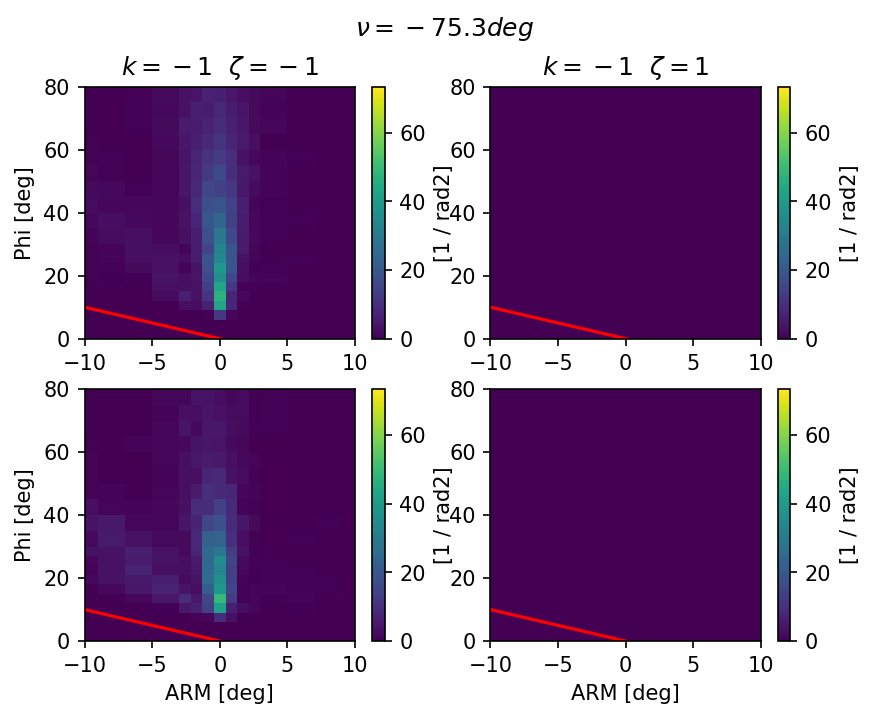

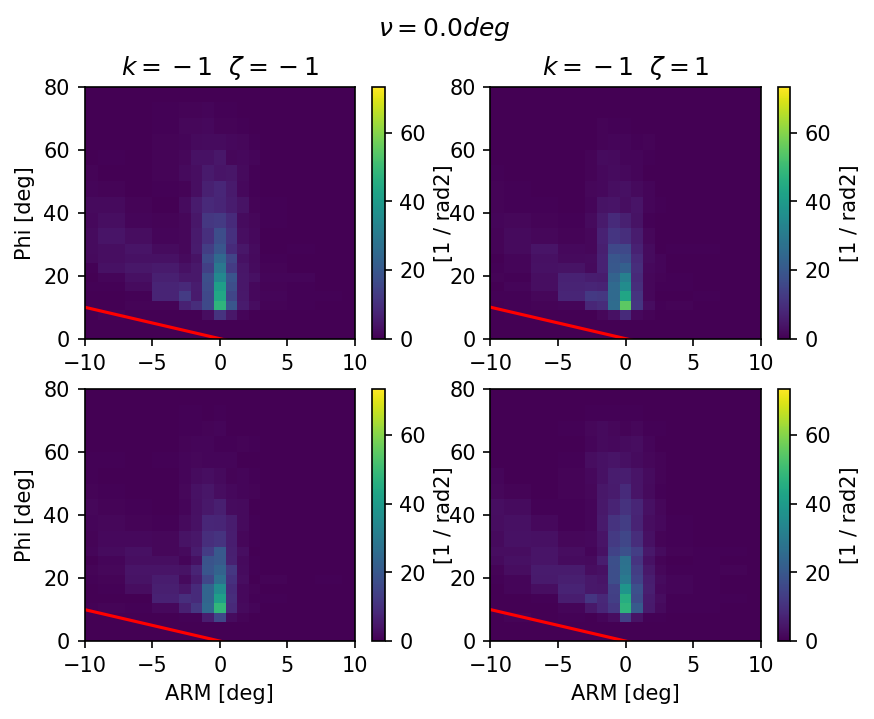

In [13]:
plot_hist = h_data_delta
plot_hist = chiral_img_dist
plot_hist = chiral_img_pdf

max_value = np.nanmax(plot_hist)
if plot_hist.unit is not None:
    max_value = max_value.value

for nNu,nu in enumerate(plot_hist.axes['Nu'].centers):
    
    if nNu not in [0,8]:
        continue
    
    fig,axes = plt.subplots(nrows = 2, ncols = 2, dpi = 150)

    for chiral_bin in [0,1]:
        for side_bin in [0,1]:
        
            ax = axes[chiral_bin,side_bin]
            
            phi_arm = plot_hist.slice[nNu,chiral_bin,:,:,side_bin].project('ARM','Phi')
        
            if side_bin == 1:
                colorbar = True
            else:
                colorbar = False
                
            colorbar = True
            
            phi_arm.plot(ax, colorbar = colorbar, vmin = 0, vmax = max_value)
        
            ax.set_xlim(-73,73)
            ax.set_xlim(-10,10)
            ax.set_ylim(0,80)
        
            if side_bin == 1:
                ax.set_ylabel(None)
            if chiral_bin == 0:
                ax.set_xlabel(None)
            
            if chiral_bin == 0:
                ax.set_title(f"$k = {chiral_bin*2-1}$  $\\zeta = {side_bin*2-1}$")
                
            x = np.linspace(-np.pi, np.pi, 100) * u.rad
            ax.plot(x.to_value(arm_axis.unit), (-x).to_value(phi_axis.unit), color = 'red')
            ax.plot(x.to_value(arm_axis.unit), (np.pi*u.rad-x).to_value(phi_axis.unit), color = 'red')
                
    fig.suptitle(f"$\\nu = {nu:.1f}$")

(<Axes: xlabel='Nu [deg]', ylabel='k'>,
 <matplotlib.collections.QuadMesh at 0x12a023b90>)

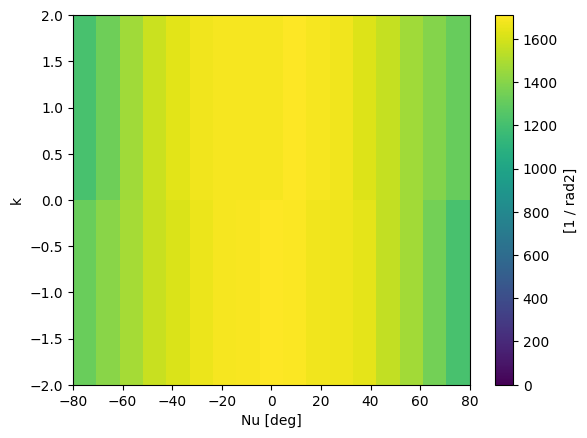

In [14]:
chiral_img_pdf.project('Nu','k').plot(vmin = 0)

(<Axes: xlabel='Nu [deg]', ylabel='Zeta'>,
 <matplotlib.collections.QuadMesh at 0x129deb200>)

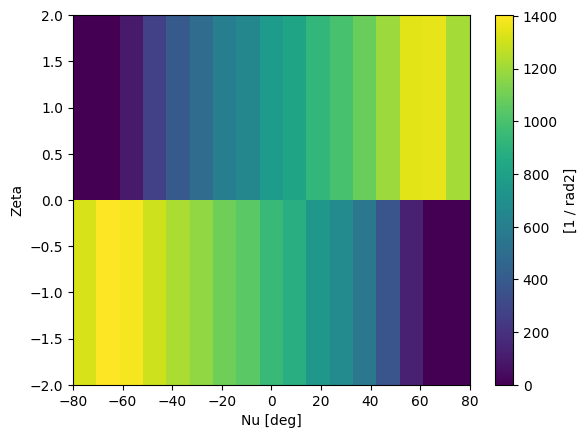

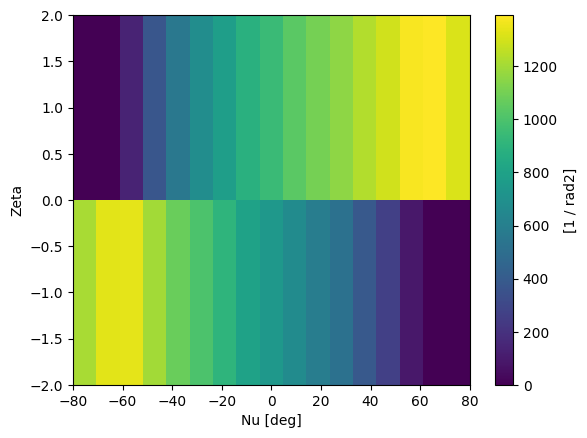

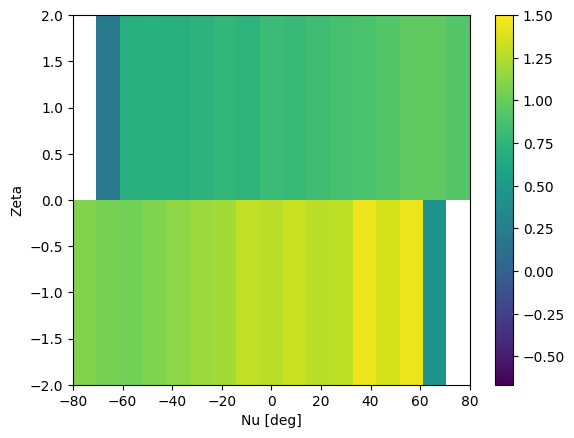

In [15]:
chiral_img_pdf.slice[{'k':0}].project('Nu','Zeta').plot(vmin = 0)
chiral_img_pdf.slice[{'k':1}].project('Nu','Zeta').plot(vmin = 0)
(chiral_img_pdf.slice[{'k':0}].project('Nu','Zeta')/chiral_img_pdf.slice[{'k':1}].project('Nu','Zeta')).plot(vmin = -1/1.5, vmax = 1.5)

/var/folders/5m/x6wxngsx5pz99ltky4nmln180000gp/T/ipykernel_74667/2087263669.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('viridis')


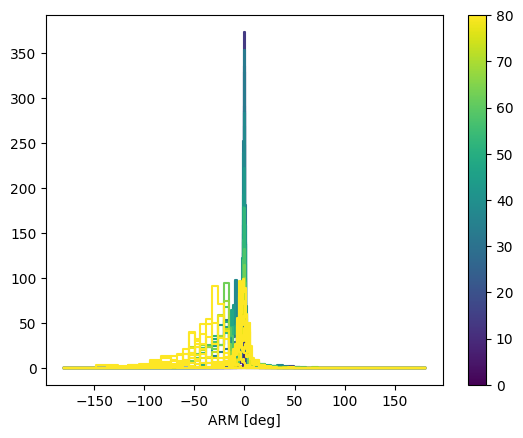

In [17]:
import matplotlib as mpl

fig,ax = plt.subplots()

cmap = mpl.cm.get_cmap('viridis')

for nPhi,phi in enumerate(h_data_delta.axes['Phi'].centers):
    h_data_delta.slice[{'Nu':0, 'Phi':nPhi}].project('ARM').plot(ax, color = cmap(phi/(80*u.deg)))

#ax.set_yscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=80))
fig.colorbar(sm, ax = ax)

/var/folders/5m/x6wxngsx5pz99ltky4nmln180000gp/T/ipykernel_74667/3725305147.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('viridis')


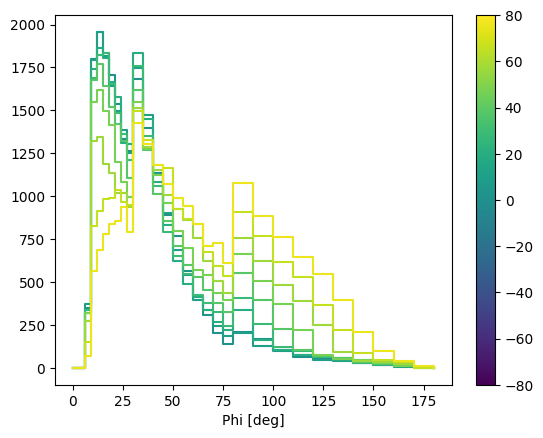

In [18]:
import matplotlib as mpl

fig,ax = plt.subplots()

cmap = mpl.cm.get_cmap('viridis')

for nNu,nu in enumerate(h_data_delta.axes['Nu'].centers):
    if nu < 0:
        continue
    h_data_delta.slice[nNu].project('Phi').plot(ax, color = cmap((nu.to_value(u.deg) + 80)/160))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-80, vmax=80))
fig.colorbar(sm, ax = ax)

/var/folders/5m/x6wxngsx5pz99ltky4nmln180000gp/T/ipykernel_74667/265312698.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('viridis')


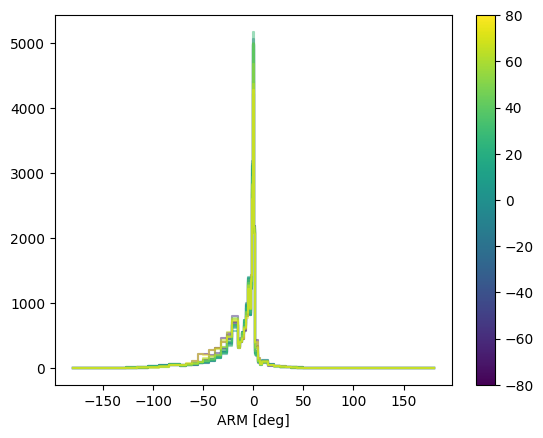

In [19]:
fig,ax = plt.subplots()

cmap = mpl.cm.get_cmap('viridis')

for nNu,nu in enumerate(h_data_delta.axes['Nu'].centers):
    h_data_delta.slice[nNu].project('ARM').plot(ax, color = cmap((nu.to_value(u.deg) + 80)/160),
                                               alpha = .5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-80, vmax=80))
fig.colorbar(sm, ax = ax)

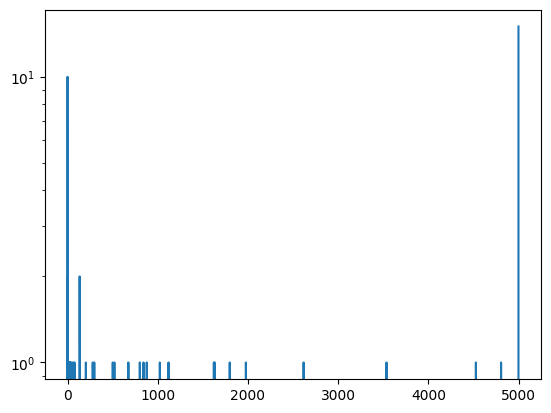

In [20]:
h_freq = Histogram(np.arange(0,5000,1))

h_freq.fill(h_data_delta.project('ARM').contents)

ax,_ = h_freq.plot()

ax.set_yscale('log')

(<Axes: xlabel='Psi [deg]', ylabel='Phi [deg]'>,
 <matplotlib.collections.QuadMesh at 0x150906d20>)

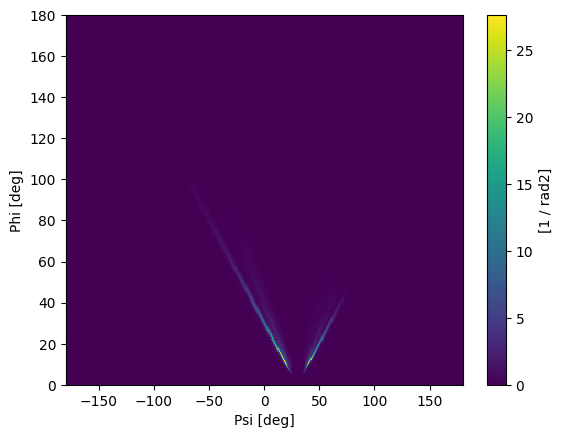

In [48]:
Nu_hyp = 30*u.deg

#pdf_phi_psi = Histogram([binned_data.axes['Psi'][180:240], binned_data.axes['Phi'][:30]], unit = 1/u.rad/u.rad)
pdf_phi_psi = Histogram(binned_data.axes, unit = 1/u.rad/u.rad)

psi = pdf_phi_psi.axes['Psi'].centers
phi = pdf_phi_psi.axes['Phi'].centers

psi,phi = np.broadcast_arrays(psi[:,None], phi[None,:], subok = True)

psi[psi > Nu_hyp + 180*u.deg] -= 360*u.deg
psi[psi < Nu_hyp - 180*u.deg] += 360*u.deg

zeta = 2*(Nu_hyp > psi) - 1

arm = np.abs(psi - Nu_hyp) - phi

chirality = 0 # PD = 0

pdf_phi_psi[:] = chiral_img_pdf.interp(Nu_hyp, chirality, phi, arm, zeta)
                                            
pdf_phi_psi.plot()             

In [50]:
int_pdf_phi_psi = pdf_phi_psi * pdf_phi_psi.axes['Psi'].widths[:,None] * pdf_phi_psi.axes['Phi'].widths[None,:]
np.sum(int_pdf_phi_psi.contents.to_value(''))

np.float64(1.0416920054163943)